In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from scipy.signal import find_peaks, peak_widths
from scipy.ndimage import gaussian_filter1d  # For smoothing
from scipy.signal import argrelextrema

from scipy.stats import linregress
from scipy.optimize import curve_fit

from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


from numba import jit, njit

In [58]:
arr_V = []
arr_scaling = []
arr_gam = []
NV = 17
for nV in range(NV):

    distance = []
    arrG0 = []
    arrGIMG = []
    arr_en = []
    arrGam = []
    shift_0 = []
    shift_IMG = []
    arr_Edis = []

    NG = 30

    N_l = 0 #selected plateou

    for nIMG in range(NG):
        Eshift_0 = np.zeros(2)
        Eshift_IMG = np.zeros(2)
        Gamma_img = np.zeros(2)
        
        #Function to re-import the data and parameters from target file
        # Read the parameters
        params_sys = {}
        with open('data%d/G_%d.dat' % (nV, nIMG), 'r') as f:
            for line in f:
                if line.startswith("#"):
                    key, value = line[1:].strip().split(" = ")
                    params_sys[key] = float(value) if '.' in value or 'e' in value.lower() else int(value)
                else:
                    break

        t, W, L, alpha, xic, plate_distance, E_dis, E_img, ei, ef, Ne, iter_dis, Ncore = params_sys.values()
        lB = 1./np.sqrt(2*np.pi*alpha)
        omB = 4*np.pi*alpha
        arr_Edis.append( E_dis/omB )
        
        distance.append( plate_distance/lB )

        # Read the data
        data = pd.read_csv('data%d/G_%d.dat' % (nV,nIMG), sep=' ', comment='#')

        energies = data['Energies'].to_numpy()
        G0 = data['G0'].to_numpy()
        GIMG = data['GIMG'].to_numpy()
        
        for nl in range(1):
            # Define a threshold: small fraction of max(fX)
            threshold_shift_IMG = .001 + (nl)
            threshold_shift_0 = .001 + (nl)
            # Find the first index where fX exceeds the threshold
            nonzero_indices_IMG = np.where(GIMG> threshold_shift_IMG)[0]
            Eshift_IMG[nl] = energies[nonzero_indices_IMG[-1]]
            # Find the first index where fX exceeds the threshold
            nonzero_indices_0 = np.where(G0 > threshold_shift_0)[0]
            Eshift_0[nl] = energies[nonzero_indices_0[-1]]
            
            Gamma_img[nl] = E_img/lB/np.abs( (plate_distance/lB)**2 ) * (nl+1)**.5/omB
        
        shift_0.append(Eshift_0)
        shift_IMG.append(Eshift_IMG)
        
        arrG0.append( G0 )
        arrGIMG.append( GIMG )
        arr_en.append(energies)
        arrGam.append( Gamma_img )
    arr_Edis = np.asarray(arr_Edis)

    arrG0 = np.asarray(arrG0)
    arrGIMG = np.asarray(arrGIMG)
    arr_en = np.asarray(arr_en)
    arrGam = np.asarray(arrGam)
    shift_0 = np.asarray(shift_0)
    shift_IMG = np.asarray(shift_IMG)
    distance = np.asarray( distance )


    def rams(x, a, b, c, s, x0):
        x = x + x0
        A = a**2*np.exp(-2*(s*x)**1)/(4*(x)*((x)+a*np.exp(-(s*x)**1)))
        phi = np.sqrt(x+a*np.exp(-(s*x)) )*c
        B = np.cos(phi)*np.exp( - b )
        f = 1/(1+A/2*(1-B)  )
        filtered_fx = np.where(x > 0, f, 0)
        
        return filtered_fx

    def rams0(x, a, x0):
        x = x + x0
        A = a**2/(4*(x)*((x)+a))
        f = 1/(1+A/2  )
        filtered_fx = np.where(x > 0, f, 0)
        return f
    
    def rams1(x, a, fact, x0):
        x = x + x0
        A = a**2/(4*(x)*((x)+a))
        f = 1/(1+A**2*fact  )
        filtered_fx = np.where(x > 0, f, 0)
        return f

    arrE_1 = np.zeros(len(distance))

    slope_1 = np.zeros(len(distance))

    inter_1 = np.zeros(len(distance))

    arr_xmin = []
    arr_ymin = []

    arr_y1 = []
    arr_x1 = []
    arr_pop = []

    N_L = 0

    t_exp = -2
    sigma_u = 1
    for nG in range(NG):
        # Extract the interval
        Ein = .001 * arrGam[nG,0]/omB
        Eout = 4 * arrGam[nG,0]/omB
        if Eout <= .4:
            ne0 = np.argmin( np.abs( Ein  - (arr_en[nG] - shift_IMG[nG][0])/ omB)  )
            nef = np.argmin( np.abs( Eout - (arr_en[nG] - shift_IMG[nG][0])/ omB) )
        else:
            ne0 = np.argmin( np.abs( 0.001  - (arr_en[nG] - shift_IMG[nG][0])/ omB)  )
            nef = np.argmin( np.abs( .4 - (arr_en[nG] - shift_IMG[nG][0])/ omB) )
        y1 = np.abs(np.flip( arrGIMG[nG, nef:ne0] ))
        x1 = np.abs( np.flip( (arr_en[nG, nef:ne0]- shift_IMG[nG][0]) / omB ) )
        
        # Find indices of local minima
        minima_indices = argrelextrema(y1, np.less)[0]
        # Extract x and y values at minima
        x_minima = x1[minima_indices]
        y_minima = y1[minima_indices]
        arr_xmin.append(x_minima)
        arr_ymin.append(y_minima)
        
        # Initial guesses for a
        p0 = [ arrGam[nG,0]/omB, -.01]
        popt1, pcov1 = curve_fit(rams0, x_minima, y_minima, p0=p0)
        # Initial guesses for a, b, c, s, x0
        #p0 = [ .5*arrGam[nG,0]/omB, 1e0, L/lB*1, 6/(arrGam[nG,0]/omB), -0.01 ]
        #popt1, pcov1 = curve_fit(rams, x1, y1, p0=p0)
        #popt1[2] = L/lB*1
        y1_fit = rams0(x1, *popt1)
        slope_1[nG] = popt1[0]
        arr_pop.append(popt1)
        #x1 = np.linspace(0,.5,300)
        #y1_fit = rams(x1, arrGam[nG,0]/omB*2, 10, np.pi*L/lB*0, 6/(arrGam[nG,0]/omB), -.03 )
        arr_y1.append( y1_fit )
        arr_x1.append( x1 )

    arr_pop = np.asarray(arr_pop)

    arr_V.append( arr_pop[:,0]/(arrGam[:,0] ) )
    arr_scaling.append( (arr_pop[20,0]) )
    arr_gam.append(arrGam[0,0])

arr_V = np.asarray(arr_V)
arr_scaling = np.asarray(arr_scaling)
arr_gam = np.asarray(arr_gam)

/var/folders/y4/dpq6l9fj2kv9z0prq_6_pyy00000gn/T/ipykernel_9504/362710430.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


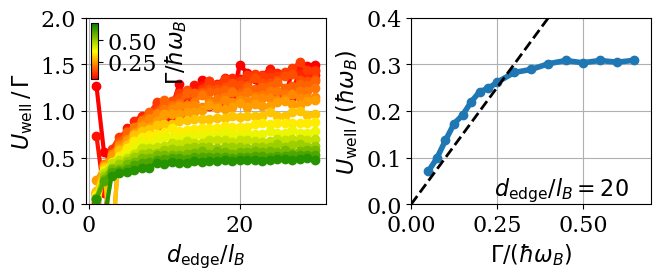

In [62]:
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors

from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes




# Font configuration
font = {
    'family': 'serif',
    'color': 'black',
    'weight': 'normal',
    'size': 16,
}
# Apply the font globally
plt.rcParams['font.family'] = font['family']
plt.rcParams['font.size'] = font['size']
plt.rcParams['axes.labelsize'] = font['size']
plt.rcParams['xtick.labelsize'] = font['size']
plt.rcParams['ytick.labelsize'] = font['size']

# Create the figure and subplots
fig, (ax3, ax2) = plt.subplots(1, 2, figsize=(8, 3))


N_l = 0

# Second plot (blue curve, right y-axis)
norm = Normalize(vmin=.1/2, vmax=1.4/2)  # Normalize gS values
#cmap = plt.get_cmap('coolwarm')  # Color map transitioning from blue to red
cmap = mcolors.LinearSegmentedColormap.from_list("red_to_grey", ["red", "yellow", "green"])
# Create ScalarMappable for colorbar
sm = ScalarMappable(norm=norm, cmap=cmap)

for nV in range(NV):
    if nV < 8:
        color = cmap(norm((.1+.05*nV)/2 ))
    elif nV >= 8 and nV<17:
        color = cmap(norm( (.4+.1*(nV-7))/2 ))
    elif nV >= 17:
        color = cmap(norm( (.4+.1*(10)+1*nV)/2 ))
    ax3.plot( distance, arr_V[nV,:], marker='o', color=color, linewidth=3, label=r'$\Gamma/\omega_B=$%.1f' % (.1+.1*nV) )


cax = inset_axes(ax3, width="3%", height="30%", loc='center left',
                 bbox_to_anchor=(-.07, .32, 1, 1), bbox_transform=ax3.transAxes, borderpad=1)

cbar = plt.colorbar(sm, cax=cax)
cbar.set_label(r'$\Gamma/\hbar \omega_B$')
cax.set_facecolor('white')
cax.patch.set_facecolor('white')



ax3.set_xlabel(r'$d_{\rm edge}/l_B$')
ax3.set_ylabel(r'$U_{\rm well}\, /\,  \Gamma $')
ax3.set_ylim(0,2.)
ax3.grid()
#ax3.legend()


arr_g = np.linspace(.0, (.1*NV/2+.8)/2, NV)
ax2.plot( arr_gam, arr_scaling, linewidth=4, marker='o', label=r'$d_{\rm edge}/l_B=30$'  )
ax2.plot( arr_g/2, arr_g/2, linewidth=2, linestyle='--', color='black', label=r''  )

ax2.set_xlabel(r'$\Gamma/(\hbar \omega_B)$')
ax2.set_ylabel(r'$U_{\rm well}\, /\, (\hbar \omega_B) $')
#ax2.legend()
ax2.grid()
ax2.set_xlim(0,.7)
ax2.set_ylim(0.,.4)

# Add manual text for ax3
ax2.text(
    1.7, -.0, r"$d_{\rm edge}/l_B=20$", 
    transform=ax3.transAxes, 
    ha='left', va='bottom', 
    fontsize=16
)


plt.tight_layout()
plt.gcf().set_size_inches(170 / 25.4, 80 / 25.4)

#plt.savefig('fig4.pdf')

plt.show()